# UChicago Trading Competition 2025 - Case 2
This is a writeup of how I arrived at the winning entry for the portfolio management leg of the UChicago Trading Competition against 40 other teams, mostly from Chicago, Stanford, and MIT. I think I had one of if not the shortest entry in terms of lines of code and complexity, and this only took me a few hours one evening to do. My goal was to approach this problem as **scientifically as possible** without instantly jumping to optimal portfolio theory and machine learning techniques.  

Text(0.5, 1.0, 'Asset Price Series')

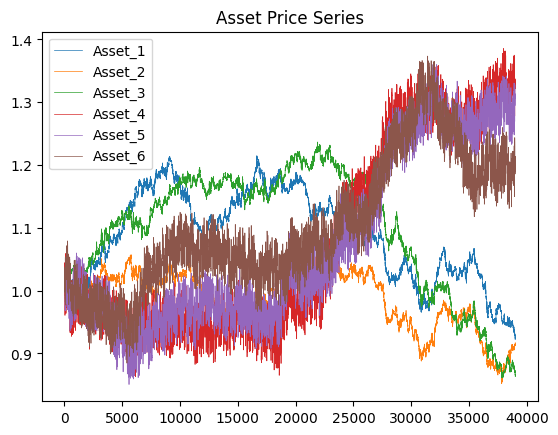

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("Case2.csv")
for i in range(1, 7):
    column = f"Asset_{i}"
    plt.plot(data[column], label=column, linewidth=0.5)  # Plot each asset's price series with thinner lines
    column_ret = f"Asset_{i}_ret"
    data[column_ret] = data[column].pct_change()  # Calculate percentage change for each asset
plt.legend()
plt.title("Asset Price Series")

## The first step: Literally zoom in on the data. 
From here, I noticed that the underlying assets were much more stable (at the tick level) then they appeared

Text(0.5, 1.0, 'Asset Price Series - Zoomed')

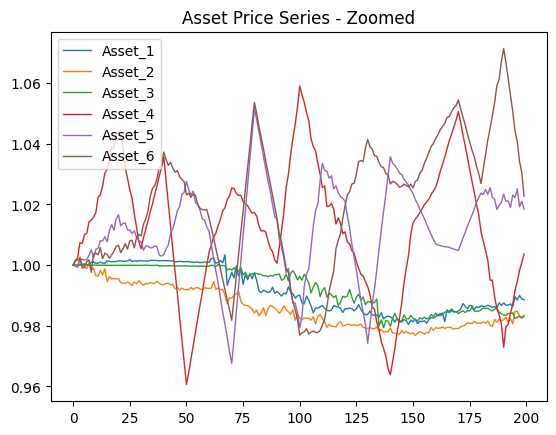

In [69]:
for i in range(1, 7):
    column = f"Asset_{i}"
    plt.plot(data[column][0:200], label=column, linewidth=1)  # Plot each asset's price series with thinner lines
    column_ret = f"Asset_{i}_ret"
plt.legend()
plt.title("Asset Price Series - Zoomed")

Though this could have also been obvious from the above plot, when I inspected the returns I realized that they would jump on exactly the 10th tick, every time. 

Text(0.5, 0.02, "Don't trade on the 10th tick")

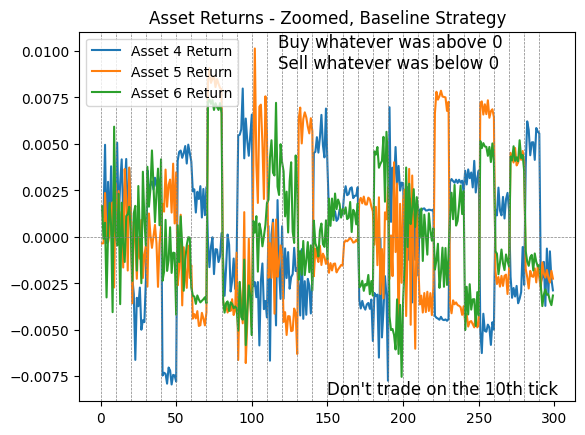

In [70]:
length = 300
plt.plot(data['Asset_4_ret'][0:length], label='Asset 4 Return')
plt.plot(data['Asset_5_ret'][0:length], label='Asset 5 Return')
plt.plot(data['Asset_6_ret'][0:length], label='Asset 6 Return')
for x in range(0, length, 10):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5) 
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5) 
plt.legend(loc='upper left')
plt.title("Asset Returns - Zoomed, Baseline Strategy")
plt.annotate("Buy whatever was above 0\nSell whatever was below 0 ", xy=(0.4, 0.9), xycoords='axes fraction', fontsize=12)
plt.annotate("Don't trade on the 10th tick", xy=(0.5, 0.02), xycoords='axes fraction', fontsize=12)

## Baseline Strategy

This is an exact implementation of that strategy: Trade whatever was above 0, sell whatever was below 0, and don't trade on the 10th tick. In retrospect this probably would've been enough to place me in the top 3

In [71]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
'''
We recommend that you change your train and test split
'''
data = pd.read_csv("Case2.csv")
TRAIN, TEST = train_test_split(data, test_size = 0.99, shuffle = False)

class Allocator():
    window_length = 500  
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        self.running_price_paths = train_data.copy()
        
        self.train_data = train_data.copy()

        self.tick_number = len(self.running_price_paths) - 1
        self.asset_4_up = None
        self.asset_5_up = None
        self.asset_6_up = None
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        self.running_price_paths = pd.concat([self.running_price_paths, pd.DataFrame([asset_prices])], ignore_index=True)
        self.tick_number += 1

        # No allocation on this turn - unknown market conditions
        if self.tick_number % 10 == 0:
            return np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  

        if self.tick_number % 10 == 1:
            # print("TICK NUMBER:", self.tick_number)
            recent_data = self.running_price_paths.tail(20).copy()
            recent_data['Asset_4_ret'] = recent_data['Asset_4'].pct_change()
            recent_data['Asset_5_ret'] = recent_data['Asset_5'].pct_change()
            recent_data['Asset_6_ret'] = recent_data['Asset_6'].pct_change()
            self.asset_4_up = recent_data['Asset_4_ret'].iloc[-1] > 0
            self.asset_5_up = recent_data['Asset_5_ret'].iloc[-1] > 0
            self.asset_6_up = recent_data['Asset_6_ret'].iloc[-1] > 0

        w4 = 0 if self.asset_4_up is None else (0.33 if self.asset_4_up else -0.33)
        w5 = 0 if self.asset_5_up is None else (0.33 if self.asset_5_up else -0.33)
        w6 = 0 if self.asset_6_up is None else (0.33 if self.asset_6_up else -0.33)

        return np.array([0.0, 0.0, 0.0, w4, w5, w6])

def grading(train_data, test_data): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        returns = returns
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, returns

sharpe_1, returns_1 = grading(TRAIN, TEST)
print(f"Sharpe: {sharpe_1}")

Sharpe: 1.3688985271838852


To evaluate this, I decided to inspect the distribution of returns:

Percent of returns less than 0: 4.312466005335543%


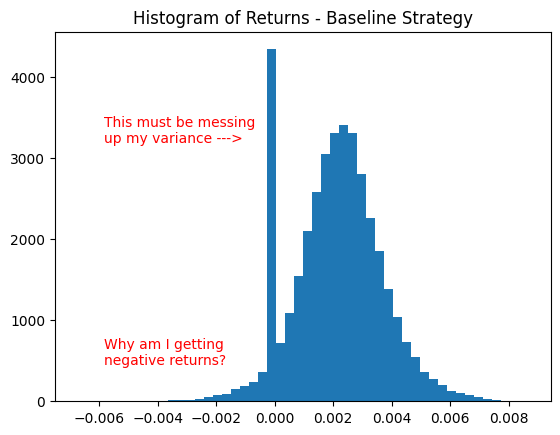

In [72]:
plt.hist(returns_1, bins=50)
plt.title("Histogram of Returns - Baseline Strategy")
plt.annotate(f"This must be messing\nup my variance --->", xy=(0.1, 0.7), xycoords='axes fraction', fontsize=10, color='red')
plt.annotate(f"Why am I getting\nnegative returns?", xy=(0.1, 0.1), xycoords='axes fraction', fontsize=10, color='red')
print(f"Percent of returns less than 0: {100*len(returns_1[returns_1 < 0])/len(returns_1)}%")

## Optimization 1: Cleaning negative returns

I decided to test if the negative returns were coming from when the assets were bouncing around 0. I decided to filter for when the return ever crossed 0 since the last jump. 

In [73]:
class Allocator():
    window_length = 500  
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        self.running_price_paths = train_data.copy()
        
        self.train_data = train_data.copy()

        self.tick_number = len(self.running_price_paths) - 1
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        self.running_price_paths = pd.concat([self.running_price_paths, pd.DataFrame([asset_prices])], ignore_index=True)
        self.tick_number += 1

        # No allocation on this turn - unknown market conditions
        idx = self.tick_number % 10
        if idx == 0:
            return np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) 
        #This is to make sure it doesn't run until we get to an index 1 the first time 
        else:
            recent_data = self.running_price_paths[['Asset_4', 'Asset_5', 'Asset_6']].tail(idx+1).copy()
            recent_data['Asset_4_ret'] = recent_data['Asset_4'].pct_change()
            recent_data['Asset_5_ret'] = recent_data['Asset_5'].pct_change()
            recent_data['Asset_6_ret'] = recent_data['Asset_6'].pct_change()
            recent_data = recent_data.dropna()

            #New addition
            w4 = 0 if (recent_data['Asset_4_ret'].min() < 0 and recent_data['Asset_4_ret'].max() > 0) else (1 if recent_data['Asset_4_ret'].min() > 0 else -1)
            w5 = 0 if (recent_data['Asset_5_ret'].min() < 0 and recent_data['Asset_5_ret'].max() > 0) else (1 if recent_data['Asset_5_ret'].min() > 0 else -1)
            w6 = 0 if (recent_data['Asset_6_ret'].min() < 0 and recent_data['Asset_6_ret'].max() > 0) else (1 if recent_data['Asset_6_ret'].min() > 0 else -1)

            return np.array([0.0, 0.0, 0.0, w4, w5, w6])

sharpe_2, returns_2 = grading(TRAIN, TEST)
print(f"Sharpe: {sharpe_2}")

Sharpe: 1.3581152800934602


Text(0.5, 1.0, 'Histogram of Returns - 2')

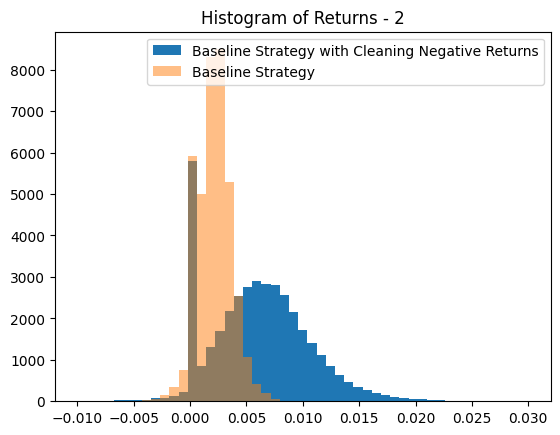

In [74]:
bins = np.linspace(-0.01, 0.03, 50)
plt.hist(returns_2, bins=bins, label="Baseline Strategy with Cleaning Negative Returns")
plt.hist(returns_1, bins=bins, alpha=0.5, label="Baseline Strategy")
plt.legend()
plt.title("Histogram of Returns - 2")

This actually reduced the sharpe by a tiny bit because it increased the right tail so much. 

In [75]:
class Allocator():
    window_length = 500  
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        self.running_price_paths = train_data.copy()
        
        self.train_data = train_data.copy()

        self.tick_number = len(self.running_price_paths) - 1
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        self.running_price_paths = pd.concat([self.running_price_paths, pd.DataFrame([asset_prices])], ignore_index=True)
        self.tick_number += 1

        # No allocation on this turn - unknown market conditions
        idx = self.tick_number % 10
        if idx == 0:
            return np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) 
        else: 
            recent_data = self.running_price_paths[['Asset_4', 'Asset_5', 'Asset_6']].tail(idx+1).copy()
            recent_data['Asset_4_ret'] = recent_data['Asset_4'].pct_change()
            recent_data['Asset_5_ret'] = recent_data['Asset_5'].pct_change()
            recent_data['Asset_6_ret'] = recent_data['Asset_6'].pct_change()
            recent_data = recent_data.dropna() 
            means = recent_data[['Asset_4_ret', 'Asset_5_ret', 'Asset_6_ret']].mean()
            abs_means = means.abs()
            max_idx = abs_means.idxmax()
            column_to_index = {'Asset_4_ret': 3, 'Asset_5_ret': 4, 'Asset_6_ret': 5}
            answer = np.zeros(6) 
            answer[column_to_index[max_idx]] = 1 * np.sign(means[max_idx])
            return answer

sharpe_3, returns_3 = grading(TRAIN, TEST)
print(f"Sharpe: {sharpe_3}")

Sharpe: 1.4103444318523786


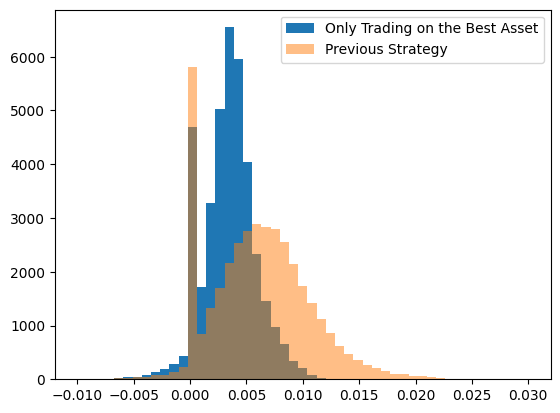

In [76]:
bins = np.linspace(-0.01, 0.03, 50)
plt.hist(returns_3, bins=bins, label="Only Trading on the Best Asset")
plt.hist(returns_2, bins=bins, alpha=0.5, label="Previous Strategy")
plt.legend()

This reduced the variance by a large amount and was a modest improvement over the previous strategy in terms of sharpe. 

## Optimization 2: Reducing the variance from the right tail

Acknowledging that my goal was solely to maximize the Expected Return over the Variance, and noticing the pattern that I could reduce the variance with the return, I had a hypothesis that I may be able to increase the sharpe by capping the return. I figured that somewhere, the additional value of return I was getting was actually increasing the variance faster then it was increasing the expected value. 

I optimized over all the possible values from the 0 to the max return I was getting and found that (interestingly enough) "capping" near the mean massively reduced the variance. 

I still wanted to trade the asset with the largest absolute return since it tended to be the most stable. This may have been a mistake on the higher idxs such as 5-9, when I might've wanted to compare the variance of all the assets above the target return

In [77]:
class Allocator():
    window_length = 500  
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        self.running_price_paths = train_data.copy()
        
        self.train_data = train_data.copy()

        self.tick_number = len(self.running_price_paths) - 1
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        self.running_price_paths = pd.concat([self.running_price_paths, pd.DataFrame([asset_prices])], ignore_index=True)
        self.tick_number += 1

        # No allocation on this turn - unknown market conditions
        idx = self.tick_number % 10
        if idx == 0: 
            return np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) 
        else: #Note: there is a strong negative autocorelation on the last change in return to this one. see what I can do with that later
            assets = ['Asset_4', 'Asset_5', 'Asset_6']
            next_returns = [0, 0, 0]
            recent_data = self.running_price_paths[assets].tail(idx+1).copy()
            for i, asset in enumerate(assets):
                value = recent_data[asset].pct_change().mean()
                next_returns[i] = value

            answer = np.zeros(6)
            max_idx = np.argmax(np.abs(next_returns))
            expected_return = abs(next_returns[max_idx])
            target_return = 0.0036
            if expected_return > target_return:
                weight = target_return / expected_return
            else:
                weight = 1
            answer[max_idx+3] = weight * np.sign(next_returns[max_idx])
            return answer

sharpe_4, returns_4 = grading(TRAIN, TEST)
print(f"Sharpe: {sharpe_4}")

Sharpe: 1.570664284653834


Text(0.8, 0.2, 'Left tail\ngets killed')

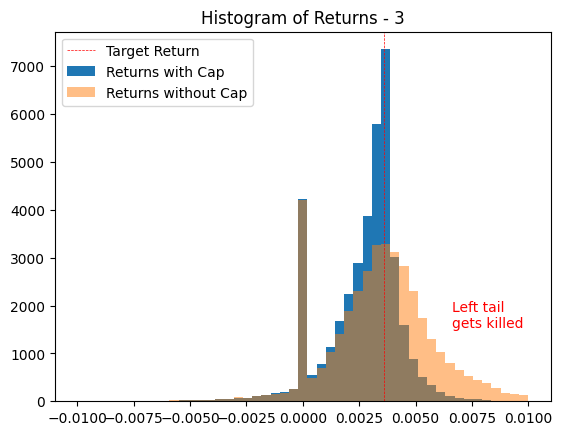

In [78]:
plt.axvline(x=0.0036, color='red', linestyle='--', linewidth=0.5, label='Target Return')
bins = np.linspace(-0.01, 0.01, 50)
plt.hist(returns_4, bins=bins, alpha=1, label='Returns with Cap')
plt.hist(returns_3, bins=bins, alpha=0.5, label='Returns without Cap')
plt.title("Histogram of Returns - 3")
plt.legend()
plt.annotate("Left tail\ngets killed", xy=(0.8, 0.2), xycoords='axes fraction', fontsize=10, color='red')

This ended up being a fairly large improvement of sharpe

## Optimization 3: Reducing Variance from the 0 peak
I had been hesistant to trade on the 10th tick because I was concerned that the returns were difficult to predict. That was still true, however, more often then not the sign of the return would flip. Therefore, to hopefully move some of the entries from 0 towards the mean, I decided to try to trade on the 10th tick. I had a "target" value that I optimized, though I made a mistake of not optimizing target with target_return at the same time. It likely would've only made a very small difference.

In [79]:
class Allocator():
    window_length = 500  
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        self.running_price_paths = train_data.copy()
        
        self.train_data = train_data.copy()

        self.tick_number = len(self.running_price_paths) - 1
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        self.running_price_paths = pd.concat([self.running_price_paths, pd.DataFrame([asset_prices])], ignore_index=True)
        self.tick_number += 1

        idx = self.tick_number % 10
        if idx == 0: #expect the return to be opposite of the last one - weigh equally
            recent_data = self.running_price_paths.tail(2).copy()
            target = 0.33
            w4 = -target if recent_data['Asset_4'].pct_change().iloc[-1] > 0 else target
            w5 = -target if recent_data['Asset_5'].pct_change().iloc[-1] > 0 else target
            w6 = -target if recent_data['Asset_6'].pct_change().iloc[-1] > 0 else target
            return np.array([0.0, 0.0, 0.0, w4, w5, w6]) 
        else: #Note: there is a strong negative autocorelation on the last change in return to this one. see what I can do with that later
            assets = ['Asset_4', 'Asset_5', 'Asset_6']
            next_returns = [0, 0, 0]
            recent_data = self.running_price_paths[assets].tail(idx+1).copy()
            for i, asset in enumerate(assets):
                if recent_data[asset].pct_change().min() < 0 and recent_data[asset].pct_change().max() > 0:
                    value = 0
                else:
                    value = recent_data[asset].pct_change().mean()
                next_returns[i] = value

            answer = np.zeros(6)
            max_idx = np.argmax(np.abs(next_returns))
            expected_return = abs(next_returns[max_idx])
            target_return = 0.0036
            if expected_return > target_return:
                weight = target_return / expected_return
                expected_return = target_return
            else:
                weight = 1

            answer[max_idx+3] = weight * np.sign(next_returns[max_idx])
            return answer

sharpe_5, returns_5 = grading(TRAIN, TEST)
print(f"Sharpe: {sharpe_5}")

Sharpe: 1.7306987660831863


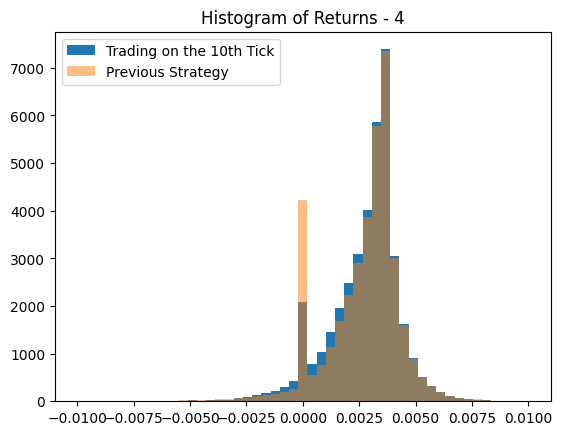

In [80]:
bins = np.linspace(-0.01, 0.01, 50)
plt.hist(returns_5, bins=bins, alpha=1, label='Trading on the 10th Tick')
plt.hist(returns_4, bins=bins, alpha=0.5, label='Previous Strategy')
plt.title("Histogram of Returns - 4")
plt.legend()

This ended up being a larger improvement then any of the previous things I had tried. 

## Other Ideas:
I should have come up with a better way to predict the return on ticks 3-9. Once the bouncing was consistent, I should have used that (either the relationships with the negative autocorrelation, or a predictive regression/ML) rather then the simple mean to predict the next step returns. However, I figured it wouldn't be a huge improvement since the asset with the largest absolute return was usually the least bouncy. 

I only know of one team that claimed a higher sharpe on the practice data than us. My guess is that they were using some overfit technique to forecast returns. 